In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import scipy.ndimage
import matplotlib.pyplot as plt
import csv
import cv2
import pickle

from glob import glob
from utils import *
from tqdm import tqdm
from multiprocessing import Pool

lidc_folder = "/home/cbel/Desktop/zhe/LIDC"
data_folder = "/home/cbel/Desktop/zhe/data"

In [2]:
# 擷取 meta.csv 中為 CT 的 uid

df_meta = pd.read_csv(lidc_folder + "/LIDC-IDRI_MetaData.csv") # length = 1398

df_CT = df_meta[df_meta["Modality"] == "CT"]
df_CT = df_CT.sort_values(by = ["Patient Id"])

array_CT_seriesuid = df_meta[df_meta["Modality"] == "CT"]["Series UID"].to_numpy()

tmp = []
patientid_uid5 = {} # patient id - series uid (末五碼)
for i in range(1018):
    if df_CT.iloc[i]["Patient Id"] not in tmp:
        tmp.append(df_CT.iloc[i]["Patient Id"])
        patientid_uid5[df_CT.iloc[i]["Patient Id"]] = [df_CT.iloc[i]["Series UID"][-5:]]
    else:
        patientid_uid5[df_CT.iloc[i]["Patient Id"]].append(df_CT.iloc[i]["Series UID"][-5:])
        
# 找出需要的 case - dicom file

case_path = {}

dcm_folder1 = glob(lidc_folder + "/dicom/*")
dcm_folder1.sort()
i = 0
for path in dcm_folder1:
    patientid = path[-14:]
    dcm_folder2 = glob(path + "/*/*")
    for path2 in dcm_folder2:
        if path2[-5:] in patientid_uid5[patientid]:
            i += 1
            case = "%04d" %i
            case_path[case] = path2

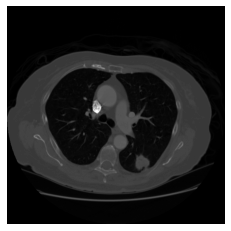

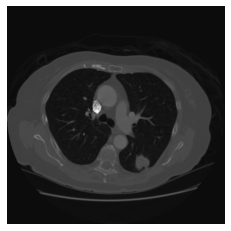

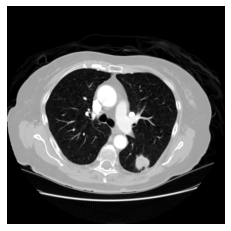

In [3]:
# generate the final calssification data and label

annotation = pd.read_csv(data_folder + "/annotation.csv")

with open(data_folder + "/coords.pickle", "rb") as file:
    all_coords = pickle.load(file)    
all_cases = list(all_coords.keys())

nodule_number = 0
check = []

# traverse every case
# for i in tqdm(range(len(all_cases))):
i = 0
case = all_cases[i]

sub_annotation = annotation[annotation["case"] == int(case)]

# load dicom file
dcm_path = glob(case_path[case] + "/*.dcm")
dcm_path.sort()
dcm = load_scan(dcm_path)
slice_thickness = float(dcm[0][0X18, 0X50].value)  # 16進制 to 10進制
pixel_spacing = float(dcm[0][0X28, 0X30].value[0])
spacing3d = np.array([dcm[0].SliceThickness, dcm[0].PixelSpacing[0], dcm[0].PixelSpacing[1]], dtype=np.float32)

# The HU in CT is a scale from black to white of 4096 values (12bit) and range -1024 HU to 3071 HU
# -1024 HU is black and represent air, 0 HU represents water, 3071 HU is white and represents densest tissue
img_hu = get_pixels_hu(dcm)

# traverse every nodule in one case
for key in all_coords[case].keys():
    ssub_annotation = sub_annotation[sub_annotation["nodule_number_percase"] == key]
    ssub_annotation = ssub_annotation.sort_values(["z"])
    annotation_z = np.round(ssub_annotation["z"].to_numpy(), decimals=1)
    diam = ssub_annotation["diam"].values[0]
    rad = max(np.array(ssub_annotation["radiologists"]))
    malignancy = ssub_annotation["malignancy"].values[0]
    max_z = max(annotation_z)
    min_z = min(annotation_z)
    for j in range(len(dcm)):
        dcm_z = np.round((dcm[j][0X20, 0X32].value[2]), decimals=1)
        if dcm_z == max_z:
            max_z_slice = j
        if dcm_z == min_z:
            min_z_slice = j
        try:
            if max_z_slice > min_z_slice:
                max_slice = max_z_slice
                min_slice = min_z_slice
            else:
                max_slice = min_z_slice
                min_slice = max_z_slice
        except:
            pass
    length = max_slice - min_slice + 1


    n = 0
    mask3d = np.zeros((length, img_hu.shape[1], img_hu.shape[2]), dtype=np.uint8)
    roi_lung = np.zeros((length, img_hu.shape[1], img_hu.shape[2]), dtype=np.int16)
    for s in range(min_slice, max_slice+1):
        dcm_z = np.round((dcm[s][0X20, 0X32].value[2]), decimals=1)
        sopuid = dcm[s][0X08, 0X18].value

        # generate mask
        masks = np.zeros((img_hu.shape[1], img_hu.shape[2]), dtype=np.uint8)
        if sopuid in ssub_annotation["SOP_UID"].values:
            coords = all_coords[case][key][sopuid]
            sub_masks = np.zeros((len(coords), img_hu.shape[1], img_hu.shape[2]), dtype=np.uint8)
            for k in range(len(coords)):
                cv2.polylines(sub_masks[k], np.int32([coords[k]]), 1, 1)
                cv2.fillPoly(sub_masks[k], np.int32([coords[k]]), 1)
            for x in range(len(sub_masks)):
                masks += sub_masks[x]
        mask3d[n] = masks
        roi_lung[n] = img_hu[s]
        n += 1

    mask3d[mask3d > 0] = 1
    mask3d = mask3d.astype(np.uint8)
    mask3d, _ = resample(mask3d, spacing3d, [1, 1, 1])
    imshow(roi_lung[4])
    roi_lung, _ = resample(roi_lung, spacing3d, [1, 1, 1])
    imshow(roi_lung[10])
    roi_lung = normalize(roi_lung)
    imshow(roi_lung[10])
    for y in range(len(mask3d)):
        if y == 0:
            if not np.unique(mask3d[y]).any():
                mask3d[y] = mask3d[y+1]
        if not np.unique(mask3d[y]).any():
            mask3d[y] = mask3d[y-1]

    if np.unique(mask3d).any():
        if len(roi_lung) == len(mask3d):
            nodule = roi_lung*mask3d
            roi_nodule = np.zeros((32, 32, 32))                    
            if len(nodule) <= 32:
                for n in range(len(nodule)):
                    m = 16 - (len(nodule)//2) + n
                    roi_nodule[m] = partition3d(nodule[n], 32)
            else:
                for n in range(32):
                    m = (len(nodule) - 32)//2 + n
                    roi_nodule[n] = partition3d(nodule[m], 32)
        else:
            print("length error case:%s nodule:%d" %(case, ssub_annotation["total_nodule_number"].values[0]))

        axial = roi_nodule[15, :, :]
        coronal = roi_nodule[:, 15, :]
        sagittal = roi_nodule[:, :, 15]

        if np.unique(axial).any() and np.unique(coronal).any() and np.unique(sagittal).any():
            nodule_number += 1
            check.append(ssub_annotation["total_nodule_number"].values[0])
            axial = axial*255
            axial = axial.astype(np.uint8)
            coronal = coronal*255
            coronal = coronal.astype(np.uint8)
            sagittal = sagittal*255
            sagittal = sagittal.astype(np.uint8)
        else:
            print("empty mask case:%s nodule:%d" %(case, ssub_annotation["total_nodule_number"].values[0]))
    else:
        print("sopuid not match case:%s nodule:%d" %(case, ssub_annotation["total_nodule_number"].values[0]))

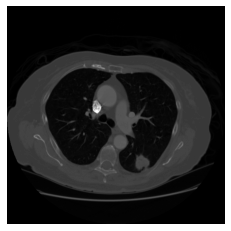

In [4]:
plt.imshow(np.squeeze(img_hu[42]), cmap="gray")
plt.axis("off")
plt.savefig(data_folder + f"/other/img_hu.tiff")
plt.show()

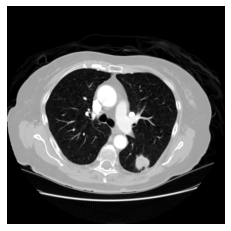

In [5]:
plt.imshow(np.squeeze(roi_lung[10]), cmap="gray")
plt.axis("off")
plt.savefig(data_folder + f"/other/img_normalize.tiff")
plt.show()

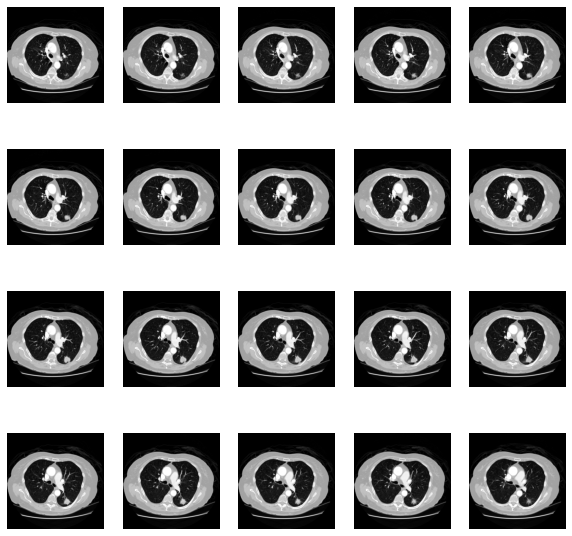

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
n=1
for i in range(0, 20, 5):
    for j in range(5):
        plt.subplot(4, 5, i+j+1)
        plt.imshow(np.squeeze(roi_lung[i+j]), cmap="gray")
        plt.axis("off")
plt.savefig(data_folder + f"/other/lung.tiff")
plt.show()

(332, 360, 360)


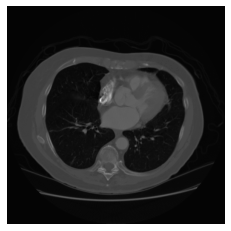

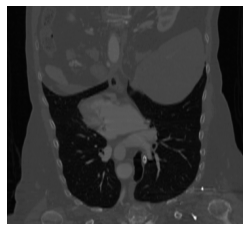

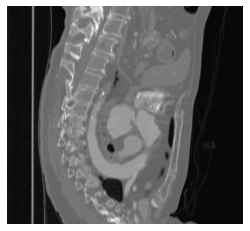

In [16]:
img_hu = get_pixels_hu(dcm)
img_hu2, _ = resample(img_hu, spacing3d, [1, 1, 1])
print(img_hu2.shape)
plt.imshow(img_hu2[166, :, :], cmap="gray")
plt.axis("off")
plt.savefig(data_folder + f"/other/lung_axial.tiff")
plt.show()
plt.imshow(cv2.flip(img_hu2[:, 180, :], -1), cmap="gray")
plt.axis("off")
plt.savefig(data_folder + f"/other/lung_coronal.tiff")
plt.show()
plt.imshow(cv2.flip(img_hu2[:, :, 180], -1), cmap="gray")
plt.axis("off")
plt.savefig(data_folder + f"/other/lung_sagittal.tiff")
plt.show()